In [1]:
%%capture
import itertools
import pickle 
import networkx as nx
from collections import deque, defaultdict, Counter
from tqdm import tqdm
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import regex as re
import math
import nltk
nltk.download('punkt')

In [2]:
with open("base_graph.pkl", 'rb') as f:
    G_directed = pickle.load(f)
f.close()
G = G_directed.to_undirected()

In [5]:
'''
# compute the best partition
partition = community_louvain.best_partition(G)

# compute modularity
mod = community_louvain.modularity(partition, G)

number_of_communities = len(set(partition.values()))
print('Using the Louvain algortihm we identified', number_of_communities, 'communities')
'''


Using the Louvain algortihm we identified 73023 communities


In [6]:
#pickle.dump(partition, open( "partition.pkl", "wb" ) )
#pickle.dump(mod, open( "mod.pkl", "wb" ) )

In [3]:
with open("partition.pkl", 'rb') as f:
    partition = pickle.load(f)
    
with open("mod.pkl", 'rb') as f:
    mod = pickle.load(f)  
    
number_of_communities = len(set(partition.values()))

In [4]:
'''
community_dict[2] = [['27c5ea64-86cb-4e69-9d13-c8ba2654515d'],
 ['2ee9a087-6188-4ebd-95b9-6561cba0584c'],
 ['efe2dd1d-706c-4ab6-bd9b-90d35a81d04f']]
'''

community_dict = {new_list: [] for new_list in range(number_of_communities)}
for i, j in partition.items():  
    community_dict[j].append([i])
    
# Filter out communities with only one element
community_dict_bigger_than_one = {k: v for k, v in community_dict.items() if len(v) > 1}

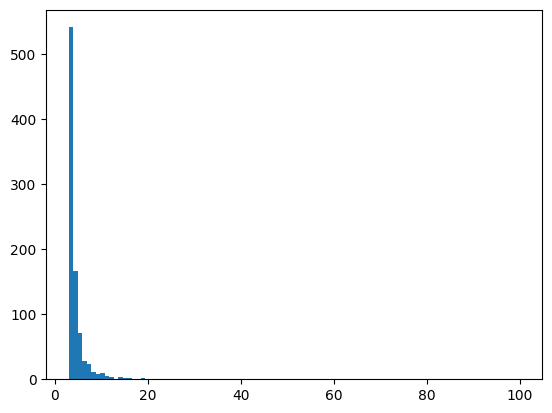

In [5]:
community_size = np.zeros(number_of_communities)

for i,j in enumerate(community_dict):
    community_size[i] = (len(community_dict[j]))
    
hist = plt.hist(community_size)
hist[0]

In [6]:
abstracts = nx.get_node_attributes(G, 'abstract')

In [7]:
community_text = {i: ' '.join(abstracts[k] for j in community_dict[i] for k in j) for i in community_dict}

In [10]:
community_text[100]

'This research focuses on the implementation of a real-time environment monitoring system for environment detection using wireless sensor networks. The purpose of our research is to construct the system on the real-time environment with the technology of environment monitoring systems and ubiquitous computing systems. Also, we present the monitoring system to provide a faster solution to prevent disasters through automatic machine controls in urgent situations. As the purpose of this study, we constructed simulation nodes with wireless sensor network devices and implemented a real-time monitoring system.'

In [ ]:
#pickle.dump(community_text, open( "community_text.pkl", "wb" ) )
with open("community_text.pkl", 'rb') as f:
    community_text = pickle.load(f)

In [13]:
def clean_and_tokenize(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    tokens = nltk.tokenize.word_tokenize(text)  # Tokenize text
    return tokens

# Apply the function to each text in community_text
community_text_clean = {i: clean_and_tokenize(text) for i, text in community_text.items()}

In [14]:
pickle.dump(community_text_clean, open( "community_text_clean.pkl", "wb" ) )

In [15]:

text_dict = {}

for i in community_text:
    no_punct = re.sub(r'[^\w\s]','',community_text[i])
    no_punct = re.sub(r'\n' , ' ', no_punct)
    no_punct = no_punct.lower()
    tokens = nltk.word_tokenize(no_punct)
    text_dict[i] = nltk.Text(tokens)
    
pickle.dump(text_dict, open( "text_dict.pkl", "wb"))


In [ ]:

#text_dict = {i: nltk.Text(nltk.word_tokenize(re.sub(r'[^\w\s]|[\n]', ' ', community_text[i]).lower())) for i in community_text}
#pickle.dump(text_dict, open("text_dict.pkl", "wb"))

with open("text_dict.pkl", 'rb') as f:
    text_dict = pickle.load(f)

In [16]:
# TF for each community
TF = {}
word_set = set()

overall_freq = Counter()
for i in community_text_clean:
    try:
        fd = nltk.FreqDist(text_dict[i])
        word_set.update(set(list(fd.keys())))
        overall_freq = overall_freq + Counter(fd)
    except:
        continue
TF[i] = overall_freq

In [ ]:
pickle.dump(TF, open("TF.pkl", "wb"))
#with open("TF.pkl", 'rb') as f:
#    TF = pickle.load(f)

In [ ]:
def idf(word):
    occ = sum(1 for i in TF if word in TF[i])
    return np.log(10 / max(1, occ))

In [ ]:
def tf_idf(number, com):    
    total_words = len(TF[number])
    return {word: (TF[number][word] / total_words) * idf(word) for word in com}

In [ ]:
tf_idf_all_communities = [tf_idf(i, TF.get(i)) for i in TF]

In [ ]:
pickle.dump(tf_idf_all_communities, open("tf_idf_all_communities.pkl", "wb")) 

In [ ]:
def idf(word):
    occ = 0
    for i in TF:
        com = TF.get(i)
        if word in com.keys():
            occ += 1
    if occ == 0:
        occ = 1
    return np.log(10/occ)

In [ ]:
def tf_idf(number, com):    
    vec = {}
    # Go through every word 
    for word in com.keys():

        # calculate the term frequency by dividing
        # the occurance of a certain word with the
        # total number of words in the commnity
        tf = TF[number][word]/len(TF[number])
        
        # calculates the inverse document frequency,
        idfreq = idf(word)

        # Then we multiply the two measures 
        val = tf*idfreq

        # save the result in a dictionary with the word
        # as the key and the TF-IDF score as the value
        vec[word] = val
    return vec

In [ ]:
TF_IDF_all_communities = []
for i in TF:
    v = tf_idf(i, TF.get(i))
    TF_IDF_all_communities.append(v)

In [ ]:
TF_IDF_all_communities


In [ ]:
TF = defaultdict(Counter)
word_set = set()

for i in community_text:
    # Join all sentences into a single string, then split and count
    overall_freq = Counter(' '.join(community_text[i]).split())
    TF[i] = overall_freq
    word_set |= set(TF[i].keys())

In [ ]:
DF = Counter()
for word in word_set:
    for i in community_text:
        if word in TF[i]:
            DF[word] += 1

# Calculate Inverse Document Frequency (IDF)
N = len(community_text)
IDF = {word: math.log(N / DF[word]) for word in DF}

In [ ]:
# Calculate TF-IDF
TF_IDF = {i: {word: TF[i][word] * IDF[word] for word in TF[i]} for i in community_text}

# Junk

In [ ]:
'''
community_text = {}
for i in community_dict:
    community_text[i] = ''
    for j in community_dict[i]:
        for k in j:
            community_text[i] = community_text[i] + abstracts[k]
'''